In [34]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import praw

user_agent = "Scraper 1.0"
reddit = praw.Reddit(
    client_id = "gscPTd0wywq_IjgqoL1Smg",
    client_secret = "UAeWcM7eWeVXQVRJLZehtFq655Dzmw",
    user_agent = user_agent
)

In [36]:
headlines = set()
for submission in reddit.subreddit('politics').hot(limit = None):
    #print(submission.title)
    #print(submission.id)
    #print(submission.author)
    #print(submission.created_utc)
    #print(submission.score)
    #print(submission.upvote_ratio)
    #print(submission.url)
    #break
    headlines.add(submission.title)
print(len(headlines))

728


In [37]:
df = pd.DataFrame(headlines)
df.head()

,0
0,US likely to send long-range ATACMS missiles t...
1,The ‘Fake’ Trump Legal Fund Playing Both Sides...
2,Supreme Court Asked by Danco to Preserve Abort...
3,"McCarthy, Under Threat From Right Flank, to En..."
4,Putin says Trump prosecution shows 'rottenness...


In [38]:
df.to_csv('headlines.csv', header = False, encoding = 'utf-8', index = False)

In [39]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width = 100 )

[{'compound': 0.0,
  'headline': 'US likely to send long-range ATACMS missiles to Ukraine for the first time: '
              'Officials',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.3182,
  'headline': 'The ‘Fake’ Trump Legal Fund Playing Both Sides and Duping Everyone',
  'neg': 0.0,
  'neu': 0.732,
  'pos': 0.268},
 {'compound': 0.5574,
  'headline': 'Supreme Court Asked by Danco to Preserve Abortion Pill Access',
  'neg': 0.0,
  'neu': 0.714,
  'pos': 0.286}]


In [41]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline
0,0.000,1.000,0.000,0.0000,US likely to send long-range ATACMS missiles t...
1,0.000,0.732,0.268,0.3182,The ‘Fake’ Trump Legal Fund Playing Both Sides...
2,0.000,0.714,0.286,0.5574,Supreme Court Asked by Danco to Preserve Abort...
3,0.248,0.584,0.168,-0.2732,"McCarthy, Under Threat From Right Flank, to En..."
4,0.286,0.714,0.000,-0.4939,Putin says Trump prosecution shows 'rottenness...


In [42]:
df['label'] = 0 
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < 0.2, 'label'] = -1
df.loc[(0.2 > df['compound']) & (df['compound'] > -0.2), 'label'] = 0
df.head()



,neg,neu,pos,compound,headline,label
0,0.000,1.000,0.000,0.0000,US likely to send long-range ATACMS missiles t...,0
1,0.000,0.732,0.268,0.3182,The ‘Fake’ Trump Legal Fund Playing Both Sides...,1
2,0.000,0.714,0.286,0.5574,Supreme Court Asked by Danco to Preserve Abort...,1
3,0.248,0.584,0.168,-0.2732,"McCarthy, Under Threat From Right Flank, to En...",-1
4,0.286,0.714,0.000,-0.4939,Putin says Trump prosecution shows 'rottenness...,-1


In [43]:
df2 = df[['headline', 'label']]

In [44]:
df2.to_csv('reddit_headline_labels.csv', encoding = 'utf-8', index = False)

In [45]:
df.label.value_counts()

 0    314
-1    249
 1    165
Name: label, dtype: int64

In [46]:
df.label.value_counts(normalize = True) * 100

 0    43.131868
-1    34.203297
 1    22.664835
Name: label, dtype: float64

In [47]:
print("Positive headlines: \n")
pprint(list(df[df['label'] == 1].headline)[:5], width = 200)

print("\nNegative headlines: \n")
pprint(list(df[df['label'] == -1].headline)[:5], width = 200)

Positive headlines: 

['The ‘Fake’ Trump Legal Fund Playing Both Sides and Duping Everyone',
 'Supreme Court Asked by Danco to Preserve Abortion Pill Access',
 'Covid Hero or ‘Lockdown Ron’? DeSantis and Trump Renew Pandemic Politics',
 'Harlan Crow Funded Ginni Thomas Group Created in Anticipation of Citizens United',
 "Ron DeSantis Spots Room For 'Pardons And Commutations' Among Sentenced Proud Boys"]

Negative headlines: 

['McCarthy, Under Threat From Right Flank, to Endorse Impeachment Inquiry',
 "Putin says Trump prosecution shows 'rottenness' of U.S. politics",
 "Fani Willis schools Congressman Jim Jordan on Constitution in response to Jordan's attempted prosecution interference",
 'Pathetic: Vivek Ramaswamy Tried to Tweet a CNN Town Hall Into Existence',
 '"Necessary to defend our republic": Republicans sue to keep Trump off ballot in battleground state - The suit alleges that Trump\'s incitement of the Jan. 6 attack disqualifies him under the 14th '
 'Amendment']


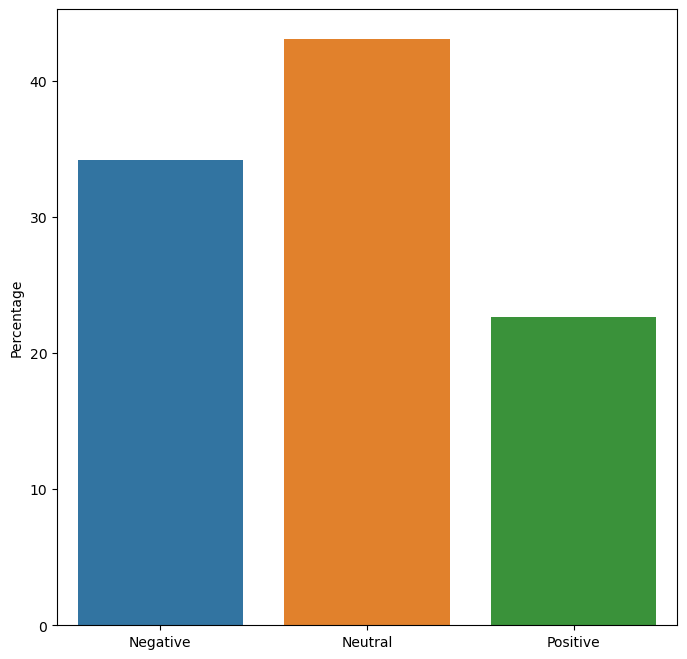

In [49]:
fig, ax = plt.subplots(figsize = (8, 8))
counts = df.label.value_counts(normalize = True)*100

sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_ylabel("Percentage")
plt.show()